models_2d_synth_stride_1_shapes_feta_192/weights_epoch_0.h5
Loaded weights from the checkpoint and continued training.
Mom:  49  Dice: 0.08013387520918001
Mom:  47  Dice: 0.14943556687984072
Mom:  53  Dice: 0.0285812218208664
Mom:  27  Dice: 0.08406367743892096
Mom:  36  Dice: 0.05807228735382797
Mom:  25  Dice: 0.18475654652897086
Mom:  23  Dice: 0.016185383244206774
Mom:  45  Dice: 0.1556783210805266
Mom:  22  Dice: 0.5416509895402213
Mom:  35  Dice: 0.04778605571350503
Mom:  18  Dice: 0.07805809691032868
Mom:  54  Dice: 0.28601804650655616
Mom:  48  Dice: 0.21058776860493836
Mom:  32  Dice: 0.12381961959766544
Mom:  33  Dice: 0.02301522951732492
Mom:  52  Dice: 0.08267887855115108
Mom:  51  Dice: 0.1525649566955363
Mom:  24  Dice: 0.28120277563608326
Mom:  29  Dice: 0.1371810701166438
Mom:  19  Dice: 0.2612884302368815
Mom:  9  Dice: 0.2858987090367428
Mom:  31  Dice: 0.15187885586090857
Mom:  37  Dice: 0.2474403394713279
Mom:  16  Dice: 0.0627874811026408
Mom:  21  Dice: 0.07420262

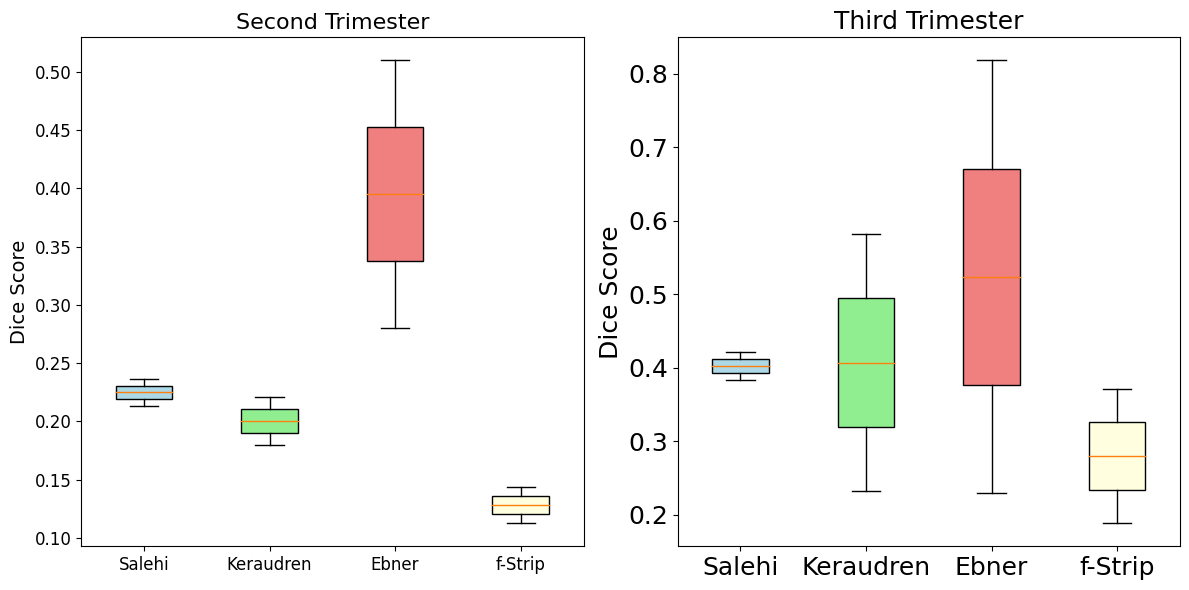

In [10]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels
import nibabel as nib
import tqdm
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
from utils import *
import pathlib
import surfa as sf
import numpy as np

import os
import numpy as np
import surfa as sf
from utils import resize
import re
import json
import numpy as np
from sklearn.metrics import f1_score

def extract_slices(inp,stride):
    out = tf.transpose(inp[0], perm=(2, 0, 1, 3))
    return out[::stride]

def process_image_2d(im, unet_model):
    a = im.copy()
    sliced_img= extract_slices(a,slice_stride)
    return unet_model.predict(sliced_img, verbose=0)


def process_image(im, unet_model):
    a = im.copy()
    return unet_model.predict(a[None,...,None], verbose=0)
    
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection) / (union) 

def my_hard_dice(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    dice = dice_coefficient(y_true_flat, y_pred_flat)
    return dice
from skimage.measure import label   

def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC
    
def soft_dice(a, b):
    dim = len(a.shape) - 2
    space = list(range(1, dim + 1))
    # print("dim",dim,"space",space,"a.dim",a.shape,"b.dim",b.shape)
    top = 2 * tf.reduce_sum(a * b, axis=space)
    bot = tf.reduce_sum(a ** 2, axis=space) + tf.reduce_sum(b ** 2, axis=space)
    
    out = tf.divide(top, bot + 1e-6)
    return -tf.reduce_mean(out)

def my_dice_coefficient(y_true, y_pred, smooth=1e-8):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)
    
def minmax_norm(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min) / (x_max - x_min)

def calculate_hard_dice_2d(image, model, mask):
    # mask = sf.load_volume(mask_filename).reshape((dim_, dim_, dim_))

    prediction_one_hot = process_image_2d(image.data[None,...,None], model)
    predictions_argmax = np.argmax(prediction_one_hot, axis=-1)
    mask.data[mask.data != 0] = 1
    prediction = tf.transpose(predictions_argmax, perm=(1, 2, 0))
    prediction = sf.Volume(prediction).reshape(mask.data.shape)

    return my_hard_dice(prediction.data.flatten(),mask.data.flatten())
    
def find_manual_mask(filename):
    base_filename, _ = os.path.splitext(filename)  # Separate filename and extension
    pattern = re.compile(rf"manual_masks_b\d+_mom_\d+_{re.escape(base_filename)}_segment\.nii\.gz")

    matches = [f for f in os.listdir("mgh_2d") if pattern.match(f)]
    
    if matches:
        return matches[0]
        
tf.get_logger().setLevel('ERROR')

warp_blur_min=np.array([2, 4, 8])
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2





random.seed(3000)

def load_model3D(checkpoint_path, slice_stride = 4, num_dim=3,nb_labels=2,
                                            dimx=192,
                                            dimy=192,
                                            dimz=192,
                                            batch_size=8,
                                            warp_max=2.5,
                                            warp_min=.5,
                                            warp_blur_min=np.array([2, 4, 8]),
                                            warp_blur_max=warp_blur_min*2,
                                            bias_blur_min=np.array([2, 4, 8]),
                                            bias_blur_max=bias_blur_min*2,
                                            initial_lr=1e-4,
                                            lr = 1e-4,
                                            lr_lin = 1e-4,
                                            nb_levels=5,
                                            conv_size=3,
                                            num_epochs=40000,
                                            num_bg_labels=16,
                                            nb_conv_per_level=2):

    
    unet_model = vxm.networks.Unet(inshape=(192,192,1), nb_features=(en, de), 
                                   nb_conv_per_level=nb_conv_per_level,
                                   final_activation_function='softmax')
    input_img = Input(shape=(192,192,192,1))
   
    sliced_img= extract_slices(input_img,slice_stride)
    segmentation = unet_model(sliced_img)

    combined_model = Model(inputs=input_img, outputs=segmentation)
    
    if os.path.exists(checkpoint_path):
        combined_model.load_weights(checkpoint_path)
        print("Loaded weights from the checkpoint and continued training.")
    else:
        print("Checkpoint file not found.")
    
    unet_model = combined_model.layers[-1]

    return unet_model

num_row = 3
per_row = 10

    
def calculate_dice_coefficient(ground_truth, predicted):
    intersection = np.sum(np.logical_and(ground_truth, predicted))
    union = np.sum(np.logical_or(ground_truth, predicted))

    dice_coefficient = (2.0 * intersection) / (union + intersection)
    return dice_coefficient

def print_row_dice_coefficients(i, row_dice_coefficients):
    formatted_dice = [f"   {dice:.4f}" for j, dice in enumerate(row_dice_coefficients)]
    num_spaces = num_row-1
    padding_left = 0
    padding_right = 0

    formatted_output = f"{' ' * padding_left}{'       '.join(formatted_dice)}{' ' * padding_right}"
    print(f' {formatted_output}')
    
def visualize(combined_model,image,mask, id):
    crop_img = image.resize([1.5, 1.5, 1.5]).reshape((dim_, dim_, dim_,1))    
    crop_data = minmax_norm(crop_img.data)
    
    prediction_one_hot = process_image(crop_data, combined_model)
    predictions_argmax = np.argmax(prediction_one_hot, axis=-1)
    prediction = np.squeeze(predictions_argmax, axis=0)

    prediction = sf.Volume(prediction)#.reshape(mask.data.shape)#.resample_like(mask)
    # mask.data[mask.data != 0] = 1
    hard_dice_score = my_hard_dice(mask.data, prediction.data)
    
    print(f"Hard Dice Coefficient: {hard_dice_score}")

    nib.save(nib.Nifti1Image(crop_img.astype(np.float32), np.eye(4), header=None), f"output/crop_img_{id}.nii.gz")
    nib.save(nib.Nifti1Image(prediction.data.astype(np.int32), np.eye(4), header=None), f"output/pred_{id}.nii.gz")
    nib.save(nib.Nifti1Image(mask.data.astype(np.int32), np.eye(4), header=None), f"output/mask_{id}.nii.gz")

    ne.plot.volume3D(crop_img);
    ne.plot.volume3D(mask);
    ne.plot.volume3D(prediction);

from scipy.ndimage import binary_closing
from scipy import ndimage

def calculate_hard_dice(image, model, mask):
    # mask = sf.load_volume(mask_filename).reshape((dim_, dim_, dim_))


    prediction_one_hot = process_image(image.data, model)
    predictions_argmax = np.argmax(prediction_one_hot, axis=-1)
    prediction = np.squeeze(predictions_argmax, axis=0)
    mask.data[mask.data != 0] = 1
    # kernel = np.ones((5, 5, 5), np.uint8)  # Adjust the kernel size as needed for 3D
    prediction = ndimage.binary_fill_holes(prediction).astype(int)
    prediction = getLargestCC(prediction)
    return my_hard_dice(prediction.flatten(),mask.data.flatten())

def evaluate(validation_folder_path, combined_model):
    subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]

    new_voxsize = [1.5,1.5,1.5]
    
    b_hard_dice_scores=[]

    b_salehi_dice_scores=[]
    b_kevin_dice_scores=[]
    b_ebner_dice_scores=[]

    latest_images=[]
    latest_masks=[]
    

    
    b_10_hard_dice_scores = []
    b_10_salehi_dice_scores = []
    b_10_ebner_dice_scores = []
    b_10_kevin_dice_scores = []

    for folder in subfolders:
        folder_path = os.path.join(validation_folder_path, folder)
        filename = os.path.join(folder_path,"image.mgz")
        mask_filename = os.path.join(folder_path,"manual.nii.gz")
        ebner_mask_filename = os.path.join(folder_path,"ebner.nii.gz")
        kevin_mask_filename = os.path.join(folder_path,"keraudren.nii.gz")
        salehi_mask_filename = os.path.join(folder_path,"salehi.nii.gz")

        
        image = sf.load_volume(filename)
        orig_voxsize = image.geom.voxsize
        crop_img = image.resize([orig_voxsize[0],orig_voxsize[1],1], method="linear")
        crop_img = crop_img.resize(new_voxsize, method="linear").reshape([dim_, dim_, dim_])
        crop_data = minmax_norm(crop_img.data)
    
        mask = sf.load_volume(mask_filename).resize([orig_voxsize[0],orig_voxsize[1],1], method="linear")
        salehi_mask = sf.load_volume(salehi_mask_filename).resize([orig_voxsize[0],orig_voxsize[1],1], method="linear")
        ebner_mask = sf.load_volume(ebner_mask_filename).resize([orig_voxsize[0],orig_voxsize[1],1], method="linear")
        kevin_mask = sf.load_volume(kevin_mask_filename).resize([orig_voxsize[0],orig_voxsize[1],1], method="linear")

        mask = mask.resize(new_voxsize).reshape([dim_, dim_, dim_, 1])
        salehi_mask = salehi_mask.resize(new_voxsize).reshape([dim_, dim_, dim_, 1])
        ebner_mask = ebner_mask.resize(new_voxsize).reshape([dim_, dim_, dim_, 1])
        kevin_mask = kevin_mask.resize(new_voxsize).reshape([dim_, dim_, dim_, 1])

        mask.data[mask.data != 0] = 1
        hard_dice_score = calculate_hard_dice_2d(crop_img, combined_model, mask)
        mom = int(folder.split("_")[1])
        print("Mom: ",mom, " Dice:",hard_dice_score)
        salehi_dice_score = my_hard_dice(salehi_mask.data, mask.data)
        ebner_dice_score = my_hard_dice(ebner_mask.data, mask.data)
        kevin_dice_score = my_hard_dice(kevin_mask.data, mask.data)

        b_10_hard_dice_scores.append(hard_dice_score)

        b_10_salehi_dice_scores.append(salehi_dice_score)
        b_10_ebner_dice_scores.append(ebner_dice_score)
        b_10_kevin_dice_scores.append(kevin_dice_score)

    b_hard_dice_scores= (np.mean(b_10_hard_dice_scores),np.std(b_10_hard_dice_scores))
    
    b_salehi_dice_scores=(np.mean(b_10_salehi_dice_scores),np.std(b_10_salehi_dice_scores))
    b_kevin_dice_scores = (np.mean(b_10_kevin_dice_scores),np.std(b_10_kevin_dice_scores))
    b_ebner_dice_scores= (np.mean(b_10_ebner_dice_scores),np.std(b_10_ebner_dice_scores))

    return b_hard_dice_scores , b_salehi_dice_scores, b_kevin_dice_scores, b_ebner_dice_scores
        
def load_models():
    with open("params_192.json", "r") as json_file:
        config = json.load(json_file)

    model1_config = config["brain"]
    model2_config = config["body"]
    model3_config = config["labels_to_image_model"]
    model4_config = config["labels_to_image_model_with_shapes"]
    
    # Convert labels_out keys to integers for all models
    model1_config["labels_out"] = {int(key): value for key, value in model1_config["labels_out"].items()}
    model2_config["labels_out"] = {int(key): value for key, value in model2_config["labels_out"].items()}
    model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
    
    model4_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
    # Now you have the modified configuration
    # Brain
    model1 = create_model(model1_config)
    # Body
    model2 = create_model(model2_config)
    # Model
    labels_to_image_model = create_model(model3_config)
    return model1, model2, labels_to_image_model
# model1, model2, labels_to_image_model = load_models()
import os, shutil, glob



synth=True
slice_stride = 1

if synth:
    models_dir='models_2d_synth_stride_'+str(slice_stride)+'_shapes_feta_192'



if synth:
    en = [16, 16, 32 ,32 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 32 ,32 ,16 ,16 ,2]
else:
    en=[16,16, 32,32, 64,64,128,128, 192,192]
    de=[192,192, 128,128,64,64,32,32,16,16,2]


nb_features = '_'.join(map(str, en))
dim_=192




last_models_hard_dice_scores = []
n = 500
# for i in range(latest_epoch, latest_epoch - n, -10):
latest_weight = max(glob.glob(os.path.join(models_dir, 'weights_epoch_*.h5')), key=os.path.getctime, default=None)

match = re.search(r'(\d+)', latest_weight.split("/")[1])
initial_epoch = int(match.group())

checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'
print(checkpoint_path)
combined_model = load_model3D(checkpoint_path,num_dim=3, dimx=dim_,
                                                       dimy=dim_,
                                                       dimz=dim_)


validation_folder_path_1="test/haste_trim2"
validation_folder_path_2="test/haste_trim3"

validation_folder_path_1="validation"
validation_folder_path_2="validation"

b2_fstrip, b2_salehi, b2_kevin , b2_ebner= evaluate(validation_folder_path_1,combined_model)
b3_fstrip, b3_salehi, b3_kevin , b3_ebner = evaluate(validation_folder_path_2,combined_model)



import matplotlib.pyplot as plt
import numpy as np

# Example data with one mean and one std for each baseline
second_trimester_data = {
    'Salehi': b2_salehi,
    'Keraudren': b2_kevin,
    'Ebner': b2_ebner,
    'f-Strip': b2_fstrip
}

third_trimester_data = {
    'Salehi': b3_salehi,
    'Keraudren': b3_kevin,
    'Ebner': b3_ebner,
    'f-Strip': b3_fstrip
}

# Create separate plots for each trimester
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Rectangular box plot for the second trimester
bplot1 = ax1.boxplot(list(second_trimester_data.values()),
                     vert=True,
                     patch_artist=True,
                     labels=list(second_trimester_data.keys()))  # will be used to label x-ticks

# Set different colors for boxes
colors1 = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, color in zip(bplot1['boxes'], colors1):
    patch.set_facecolor(color)

ax1.set_title('Second Trimester', fontsize=16)
ax1.set_ylabel('Dice Score', fontsize=14)
ax1.tick_params(axis='both', labelsize=12)

# Rectangular box plot for the third trimester
bplot2 = ax2.boxplot(list(third_trimester_data.values()),
                     vert=True,
                     patch_artist=True,
                     labels=list(third_trimester_data.keys()))  # will be used to label x-ticks

# Set different colors for boxes
colors2 = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, color in zip(bplot2['boxes'], colors2):
    patch.set_facecolor(color)

ax2.set_title('Third Trimester', fontsize=18)
ax2.set_ylabel('Dice Score', fontsize=18)
ax2.tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.show()


In [38]:
# image = sf.load_volume("test/haste_trim3/mom_011__30wk__8T2_Haste_Sag_mm_400_FOV/image.mgz")
# mask = np.zeros(image.shape)
# nib.save(nib.Nifti1Image(mask.astype(np.int32), np.eye(4), header=None), f"test/haste_trim3/mom_011__30wk__8T2_Haste_Sag_mm_400_FOV/salehi.nii.gz")
# nib.save(nib.Nifti1Image(mask.astype(np.int32), np.eye(4), header=None), f"test/haste_trim3/mom_011__30wk__8T2_Haste_Sag_mm_400_FOV/ebner.nii.gz")
# nib.save(nib.Nifti1Image(mask.astype(np.int32), np.eye(4), header=None), f"test/haste_trim3/mom_011__30wk__8T2_Haste_Sag_mm_400_FOV/keraudren.nii.gz")


In [24]:
b2_fstrip

(0.3695936228104438, 0.259286525217361)

In [7]:
b2_ebner

(0.5097837854251172, 0.2799922897552792)